# Mapping Emotion
### Sentiment Analysis of Fitzgerald’s Novels Using VADER and Cardiff RoBERTa

This notebook analyzes the emotional tone in F. Scott Fitzgerald’s novels using two sentiment analysis models: VADER (a rule-based model) and CardiffNLP’s RoBERTa (a transformer-based model fine-tuned model).

Cleaned, sentence-level text is loaded for each novel. Sentiment scores are computed using both models, aggregated by chapter, and compared to explore how each method captures emotional patterns across the narratives. The results are visualized to highlight trends and differences in sentiment over the course of each book.

## Import Libraries

In [1]:
%run ../notebooks/setup_path.py
from config import *

# Utilities
import re
import requests
import csv
import numpy as np

# Text processing
import nltk
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK resources
nltk.download('vader_lexicon')

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Transformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
c:\Users\Virginia\Python\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## VADER

This section applies the VADER sentiment analyzer to each sentence in the cleaned texts. VADER, part of the NLTK library, is designed to assess sentiment in everyday English, assigning scores for positive, neutral, and negative tone, along with an overall compound score.

The sentiment scores are saved per book and used to compute average sentiment values, offering an initial view of the emotional tone throughout each novel. This provides a foundation for exploring how mood shifts across and within Fitzgerald’s works. 

In [2]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

print("== Sentiment Analysis: VADER ==")

for title in BOOKS:

    clean_path = PROCESSED_DIR / f"{title}-cleaned.txt"
    output_path = VADER_RESULTS_DIR / f"{title}-sentiment-analysis-per-sentence-vader.csv"

    if not clean_path.exists():
        print(f"File not found: {clean_path}")
        continue

    # Read cleaned sentences from file
    with open(clean_path, "r", encoding = "utf-8") as f:
        sentences = [line.strip() for line in f if line.strip()]

    sentiment_data = []
    for sentence in sentences:
        scores = sia.polarity_scores(sentence)
        sentiment_data.append({
            "sentence": sentence,
            "neg": scores["neg"],
            "neu": scores["neu"],
            "pos": scores["pos"],
            "compound": scores["compound"]
        })

    # Save sentiment results to CSV
    with open(output_path, "w", encoding = "utf-8", newline = "") as f:
        writer = csv.DictWriter(f, fieldnames=["sentence", "neg", "neu", "pos", "compound"])
        writer.writeheader()
        writer.writerows(sentiment_data)

    # Calculate average compound score
    avg_score = sum(d["compound"] for d in sentiment_data) / len(sentiment_data) if sentiment_data else 0

    # Determine overall sentiment label
    if avg_score > 0.05:
        label = "Positive"
    elif avg_score < -0.05:
        label = "Negative"
    else:
        label = "Neutral"


    # Output summary
    print(f"\nTitle: {title.replace('-', ' ').title()}")
    print(f"Average Sentiment Score: {avg_score:.2f}")
    print(f"Overall Sentiment Label: {label}")
    print("-" * 60)

== Sentiment Analysis: VADER ==

Title: This Side Of Paradise
Average Sentiment Score: 0.06
Overall Sentiment Label: Positive
------------------------------------------------------------

Title: The Beautiful And Damned
Average Sentiment Score: 0.04
Overall Sentiment Label: Neutral
------------------------------------------------------------

Title: The Great Gatsby
Average Sentiment Score: 0.03
Overall Sentiment Label: Neutral
------------------------------------------------------------


The sentiment analysis shows that all three novels have a slightly positive overall tone. *This Side of Paradise* comes across as a bit more upbeat compared to the other two, which lean closer to neutral. That fits with its youthful and hopeful vibe, while *The Beautiful and Damned* and *The Great Gatsby* feel a bit more calm emotionally.

It’s worth keeping in mind that this kind of sentence-level, lexicon-based analysis can miss some of the complexity, like irony or deeper context. Still, it gives a good general sense of the emotional mood in each book.

Further exploration of sentiment at chapter level may offer deeper insight into how the emotional tone evolves throughout each novel.

In [3]:
def split_into_chapters(text):
    """
    Splits a full text into chapters based on common chapter headings.

    Recognizes patterns like "Chapter 1", "Chapter I", "Chapter One", etc.

    Parameters:
    ----------
        text (str): The full raw text of a book or document.

    Returns:
    ----------
        List[Tuple[str, str]]: A list of tuples, each containing:
            - chapter title (e.g., 'Chapter 1')
            - chapter text (stripped of leading/trailing whitespace)
    """
    chapter_pattern = re.compile(r"(?:^|\n)(chapter [ivxlc\d]+|chapter \w+)", re.IGNORECASE)
    splits = chapter_pattern.split(text)
    chapters = []
    for i in range(1, len(splits), 2):
        chapter_title = splits[i].strip()
        chapter_text = splits[i+1] if i+1 < len(splits) else ""
        chapters.append((chapter_title, chapter_text.strip()))
    return chapters


def chapter_sentiment(chapters):
    """
    Performs sentiment analysis on each chapter based on sentence-level compound scores.

    Aggregates sentence-level sentiment scores into an average score for the chapter
    and assigns an overall sentiment label.

    Parameters:
    ----------
        chapters (List[Tuple[str, str]]): List of (chapter_title, chapter_text) pairs.

    Returns:
    ----------
        List[Dict]: A list of dictionaries for each chapter containing:
            - 'chapter': title of the chapter
            - 'avg_compound': average compound sentiment score
            - 'num_sentences': number of sentences in the chapter
            - 'sentiment_label': overall sentiment label ('Positive', 'Negative', 'Neutral')
    """
    chapter_scores = []
    for title, text in chapters:
        sentences = sent_tokenize(text)
        scores = [sia.polarity_scores(s)["compound"] for s in sentences if s.strip()]
        avg_score = sum(scores) / len(scores) if scores else 0

        if avg_score > 0.05:
            label = "Positive"
        elif avg_score < -0.05:
            label = "Negative"
        else:
            label = "Neutral"

        chapter_scores.append({
            "chapter": title,
            "avg_compound": avg_score,
            "num_sentences": len(sentences),
            "sentiment_label": label
        })
    return chapter_scores

In [4]:
print("== Sentiment Analysis Per Chapter: VADER ==")

for title in BOOKS:

    clean_path = PROCESSED_DIR / f"{title}-cleaned.txt"
    output_path = VADER_RESULTS_DIR / f"{title}-sentiment-analysis-per-chapter-vader.csv"

    if not clean_path.exists():
        print(f"File not found: {clean_path}")
        continue

    with open(clean_path, "r", encoding="utf-8") as f:
        text = f.read()

    chapters = split_into_chapters(text)
    chapter_scores = chapter_sentiment(chapters)
    
    # Save results
    with open(output_path, "w", encoding = "utf-8", newline = "") as f:
        writer = csv.DictWriter(f, fieldnames=["chapter", "avg_compound", "num_sentences", "sentiment_label"])
        writer.writeheader()
        writer.writerows(chapter_scores)

    # Output summary
    print(f"\nTitle: {title.replace('-', ' ').title()}\n")
    for ch in chapter_scores:
        print(f"{ch['chapter']:<12}: Average Compound Sentiment: {ch['avg_compound']:.2f} — {ch['sentiment_label']}")
    print("-" * 60)

== Sentiment Analysis Per Chapter: VADER ==

Title: This Side Of Paradise

CHAPTER I   : Average Compound Sentiment: 0.11 — Positive
CHAPTER II  : Average Compound Sentiment: 0.09 — Positive
CHAPTER III : Average Compound Sentiment: 0.01 — Neutral
CHAPTER IV  : Average Compound Sentiment: 0.05 — Positive
CHAPTER I   : Average Compound Sentiment: 0.10 — Positive
CHAPTER II  : Average Compound Sentiment: 0.04 — Neutral
CHAPTER III : Average Compound Sentiment: 0.05 — Positive
CHAPTER IV  : Average Compound Sentiment: -0.02 — Neutral
CHAPTER V   : Average Compound Sentiment: 0.01 — Neutral
------------------------------------------------------------

Title: The Beautiful And Damned

CHAPTER I   : Average Compound Sentiment: 0.13 — Positive
CHAPTER II  : Average Compound Sentiment: 0.09 — Positive
CHAPTER III : Average Compound Sentiment: 0.06 — Positive
CHAPTER I   : Average Compound Sentiment: 0.05 — Neutral
CHAPTER II  : Average Compound Sentiment: 0.02 — Neutral
CHAPTER III : Average C

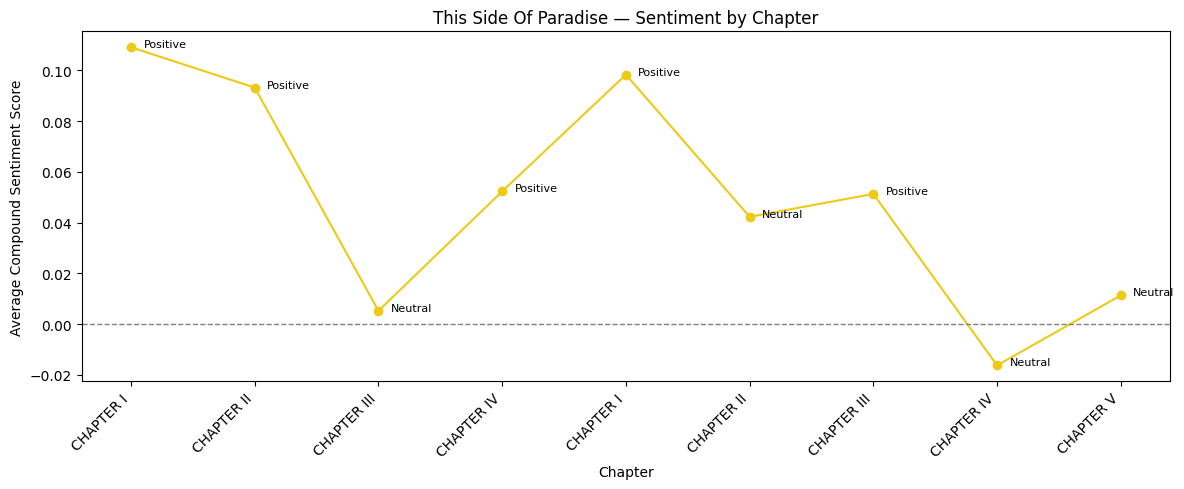

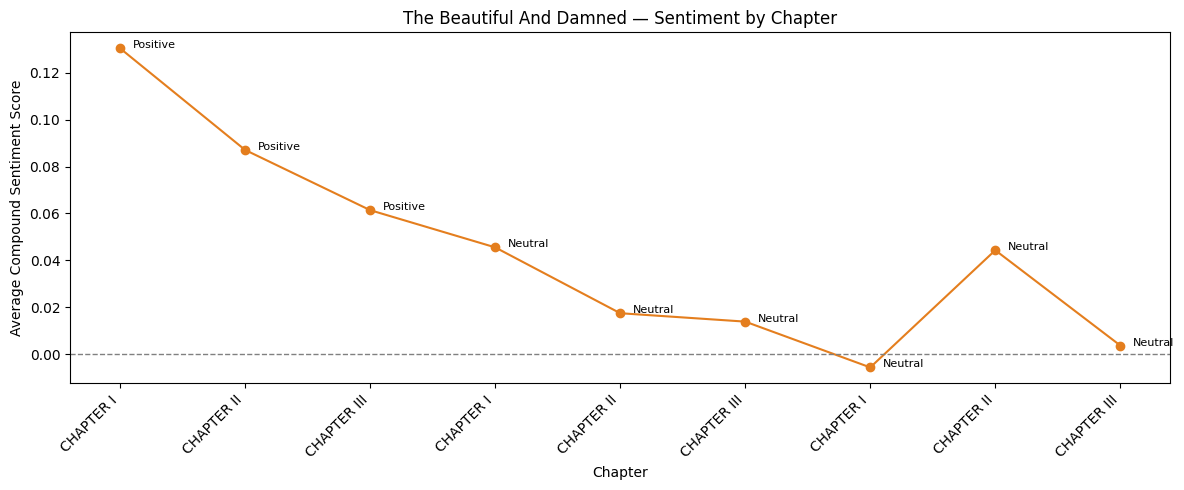

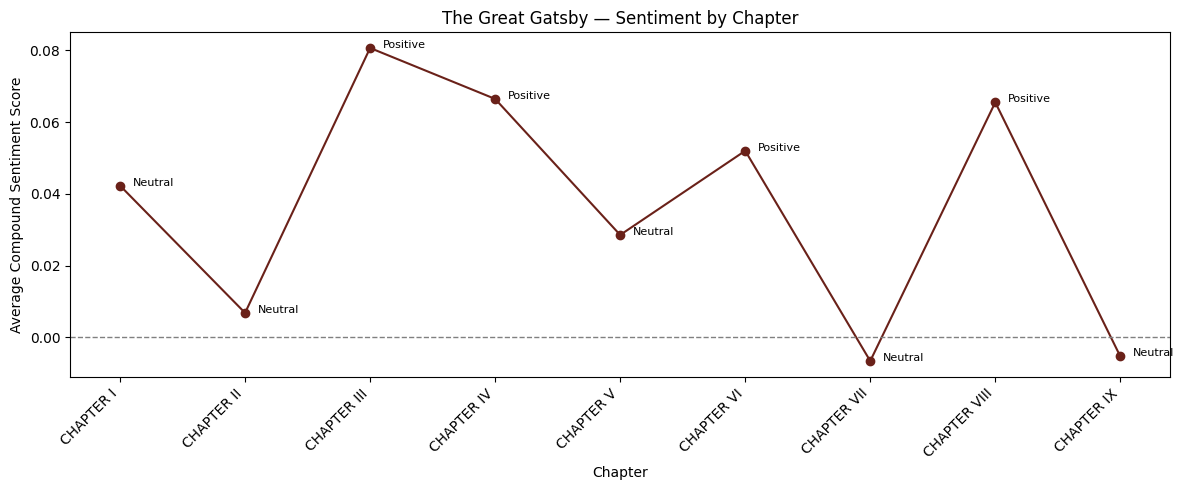

In [5]:
colors = ["#eeca16", "#e47e1e", "#6a2119"]

for title, color in zip(BOOKS, colors):

    csv_path = VADER_RESULTS_DIR / f"{title}-sentiment-analysis-per-chapter-vader.csv"
    figure_path = VADER_FIGURES_DIR / f"{title}-sentiment-analysis-per-chapter-vader.png"

    if not clean_path.exists():
        print(f"File not found: {clean_path}")
        continue

    chapters = []
    scores = []
    labels = []

    # Load CSV data
    with open(csv_path, "r", encoding = "utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            chapters.append(row["chapter"])
            scores.append(float(row["avg_compound"]))
            labels.append(row["sentiment_label"])

    # Clean book title
    pretty_title = title.replace("-", " ").title()

    # Plot
    plt.figure(figsize = (12, 5))
    plt.plot(scores, marker = "o", color = color)

    for i, label in enumerate(labels):
        plt.text(i + 0.1, scores[i], label, fontsize = 8)

    plt.axhline(0, color = "gray", linestyle = "--", linewidth = 1)
    plt.xticks(ticks = range(len(chapters)), labels = chapters, rotation = 45, ha = "right")
    plt.title(f"{pretty_title} — Sentiment by Chapter")
    plt.xlabel("Chapter")
    plt.ylabel("Average Compound Sentiment Score")
    plt.tight_layout()
    plt.savefig(figure_path)

Looking at the sentiment by chapter, *This Side of Paradise* generally stays on the positive side, especially in the beginning, though some chapters later on are more neutral. *The Beautiful and Damned* starts off positive but then mostly stays neutral. *The Great Gatsby* goes back and forth between neutral and a little positive, with a few chapters dropping back to neutral. Overall, the feelings in the books switch between a bit of positivity and neutral, matching how the stories go up and down.

## Cardiff RoBERTa

The next part of the analysis shifts from the basic VADER tool to the more advanced Cardiff RoBERTa model. While VADER offers a simple, lexicon-based approach that is easy to apply, it can struggle to capture the complexity and nuance typical of literary texts. In contrast, Cardiff RoBERTa is a transformer-based model fine-tuned specifically for sentiment analysis. Transformers use self-attention mechanisms to weigh the importance of different words in a sentence relative to each other, allowing the model to understand context and relationships more effectively. This ability enables Cardiff RoBERTa to detect subtle emotional cues that rule-based methods like VADER might miss. Applying this model provides a deeper and more nuanced understanding of sentiment in Fitzgerald’s novels, revealing layers of meaning beyond simple positive or negative classifications.

### Sentiment Scoring for Comparison

To compare the outputs of VADER and Cardiff RoBERTa more directly, a simple scoring system was applied to the RoBERTa predictions. While VADER provides a continuous sentiment score ranging from -1 to 1 along with a sentiment label, RoBERTa’s categorical predictions were converted into a numeric scale for consistency.

Each sentence classified by RoBERTa was assigned a score based on its predicted label:

* **Positive** → +1
* **Neutral** → 0
* **Negative** → -1

The average sentiment score across all sentences in each novel was then calculated, and an overall sentiment label was assigned using the same thresholds applied in the VADER analysis:

* Score > 0.05 → **Positive**
* Score < -0.05 → **Negative**
* Otherwise → **Neutral**

Though this scoring approach simplifies RoBERTa’s probability-based predictions, it allows for a consistent, comparable framework alongside VADER’s results. This method helps reveal general sentiment trends across the novels, while recognizing that each model interprets language and context differently.

In [6]:
# Load the model and tokenizer
transformer_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)
transformer_model = AutoModelForSequenceClassification.from_pretrained(transformer_model_name)

# Class labels for this model
transformer_labels = ["Negative", "Neutral", "Positive"]

def transformer_sentiment(text):
    """
    Analyze the sentiment of a given text sentence using the Cardiff RoBERTa transformer model.
    
    Parameters: 
    ----------
        text (str): The sentence to analyze.
    
    Returns:
    ----------
        dict: A dictionary mapping sentiment labels ('Negative', 'Neutral', 'Positive') to their respective probability scores.
    """
    inputs = tokenizer(text, return_tensors = "pt", truncation = True, max_length = 512)
    with torch.no_grad():
        outputs = transformer_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim = 1).squeeze().tolist()
    return dict(zip(transformer_labels, probs))

In [7]:
#  VADER-style Sentiment Label Mapping
score_map = {"Negative": -1, "Neutral": 0, "Positive": 1}

print("== Sentiment Analysis: Cardiff RoBERTa Transformer ==")
print("\nNOTE: The output of the transformer model has been mapped to match VADER's format")
print("      (using -1 for Negative, 0 for Neutral, +1 for Positive) for comparison purposes.")
print("      This mapping is a simplification and may not reflect the full nuance of the model.\n")


for title in BOOKS:
    
    clean_path = PROCESSED_DIR / f"{title}-cleaned.txt"
    output_path = TRANSFORMER_RESULTS_DIR / f"{title}-sentiment-analysis-per-sentence-cardiff-roberta.csv"

    if not clean_path.exists():
        print(f"File not found: {clean_path}")
        continue
    
    # Load cleaned sentences
    with open(clean_path, "r", encoding="utf-8") as f:
        sentences = [line.strip() for line in f if line.strip()]

    results = []
    for sentence in sentences:
        scores = transformer_sentiment(sentence)
        results.append({
            "sentence": sentence,
            "negative": scores["Negative"],
            "neutral": scores["Neutral"],
            "positive": scores["Positive"],
            "predicted_label": max(scores, key=scores.get)
        })

    with open(output_path, "w", encoding="utf-8", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["sentence", "negative", "neutral", "positive", "predicted_label"])
        writer.writeheader()
        writer.writerows(results)

    # VADER-style output summary
    """ Disclaimer:
    To compare transformer sentiment results with VADER, we map RoBERTa's predicted labels to numeric values: -1 for Negative, 0 for Neutral, +1 for Positive.
    This allows us to compute an average sentiment score similar to VADER's, but is a simplified approximation of the model’s more nuanced output.
    """
    total_score = 0
    label_counts = {"Negative": 0, "Neutral": 0, "Positive": 0}

    for r in results:
        label = r["predicted_label"]
        label_counts[label] += 1
        total_score += score_map[label]

    avg_score = total_score / len(results) if results else 0

    if avg_score > 0.05:
        overall_label = "Positive"
    elif avg_score < -0.05:
        overall_label = "Negative"
    else:
        overall_label = "Neutral"

    # Final formatted summary (matches VADER output)
    print(f"\nTitle: {title.replace('-', ' ').title()}")
    print(f"Average Sentiment Score: {avg_score:.2f}")
    print(f"Overall Sentiment Label: {overall_label}")
    print("-" * 60)

== Sentiment Analysis: Cardiff RoBERTa Transformer ==

NOTE: The output of the transformer model has been mapped to match VADER's format
      (using -1 for Negative, 0 for Neutral, +1 for Positive) for comparison purposes.
      This mapping is a simplification and may not reflect the full nuance of the model.


Title: This Side Of Paradise
Average Sentiment Score: -0.07
Overall Sentiment Label: Negative
------------------------------------------------------------

Title: The Beautiful And Damned
Average Sentiment Score: -0.07
Overall Sentiment Label: Negative
------------------------------------------------------------

Title: The Great Gatsby
Average Sentiment Score: -0.03
Overall Sentiment Label: Neutral
------------------------------------------------------------


As done with VADER, a sentiment analysis per chapter is done using Cardiff RoBERTa model. 

In [8]:
def transformer_chapter_sentiment(chapters):
    """
    Perform sentiment analysis on each chapter using CardiffNLP RoBERTa,
    and output average sentiment score (mapped like VADER) per chapter.
    """
    chapter_scores = []

    for chapter_title, chapter_text in chapters:
        sentences = sent_tokenize(chapter_text)
        predictions = [transformer_sentiment(s) for s in sentences if s.strip()]

        # Get predicted label per sentence
        predicted_labels = [max(p, key=p.get) for p in predictions]

        total_score = sum(score_map[label] for label in predicted_labels)
        avg_score = total_score / len(predicted_labels) if predicted_labels else 0

        if avg_score > 0.05:
            sentiment_label = "Positive"
        elif avg_score < -0.05:
            sentiment_label = "Negative"
        else:
            sentiment_label = "Neutral"

        chapter_scores.append({
            "chapter": chapter_title,
            "avg_sentiment_score": avg_score,
            "num_sentences": len(predicted_labels),
            "sentiment_label": sentiment_label
        })

    return chapter_scores

In [11]:
print("== Sentiment Analysis per Chapter: Cardiff RoBERTa Transformer ==")
print("\nNOTE: RoBERTa labels mapped to VADER-style sentiment scores (-1, 0, +1)\n")

for title in BOOKS:

    clean_path = PROCESSED_DIR / f"{title}-cleaned.txt"
    output_path = TRANSFORMER_RESULTS_DIR / f"{title}-sentiment-analysis-per-chapter-cardiff-roberta.csv"

    if not clean_path.exists():
        print(f"File not found: {clean_path}")
        continue

    with open(clean_path, "r", encoding="utf-8") as f:
        text = f.read()

    chapters = split_into_chapters(text)
    chapter_scores = transformer_chapter_sentiment(chapters)

    with open(output_path, "w", encoding="utf-8", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["chapter", "avg_sentiment_score", "num_sentences", "sentiment_label"])
        writer.writeheader()
        writer.writerows(chapter_scores)

    # Ouput summary
    print(f"\nTitle: {title.replace('-', ' ').title()}\n")
    for ch in chapter_scores:
        print(f"{ch['chapter']:<12}: Average Sentiment Score: {ch['avg_sentiment_score']:.2f} — {ch['sentiment_label']}")
    print("-" * 60)

== Sentiment Analysis per Chapter: Cardiff RoBERTa Transformer ==

NOTE: RoBERTa labels mapped to VADER-style sentiment scores (-1, 0, +1)


Title: This Side Of Paradise

CHAPTER I   : Average Sentiment Score: 0.02 — Neutral
CHAPTER II  : Average Sentiment Score: 0.01 — Neutral
CHAPTER III : Average Sentiment Score: -0.13 — Negative
CHAPTER IV  : Average Sentiment Score: -0.11 — Negative
CHAPTER I   : Average Sentiment Score: -0.04 — Neutral
CHAPTER II  : Average Sentiment Score: -0.13 — Negative
CHAPTER III : Average Sentiment Score: -0.06 — Negative
CHAPTER IV  : Average Sentiment Score: -0.10 — Negative
CHAPTER V   : Average Sentiment Score: -0.17 — Negative
------------------------------------------------------------

Title: The Beautiful And Damned

CHAPTER I   : Average Sentiment Score: 0.01 — Neutral
CHAPTER II  : Average Sentiment Score: 0.01 — Neutral
CHAPTER III : Average Sentiment Score: -0.03 — Neutral
CHAPTER I   : Average Sentiment Score: -0.08 — Negative
CHAPTER II  : Av

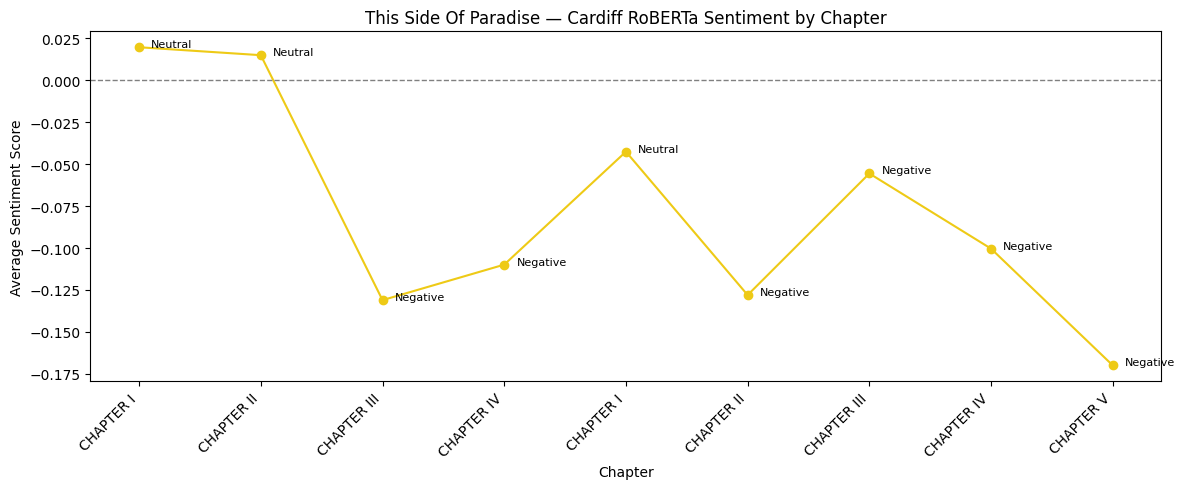

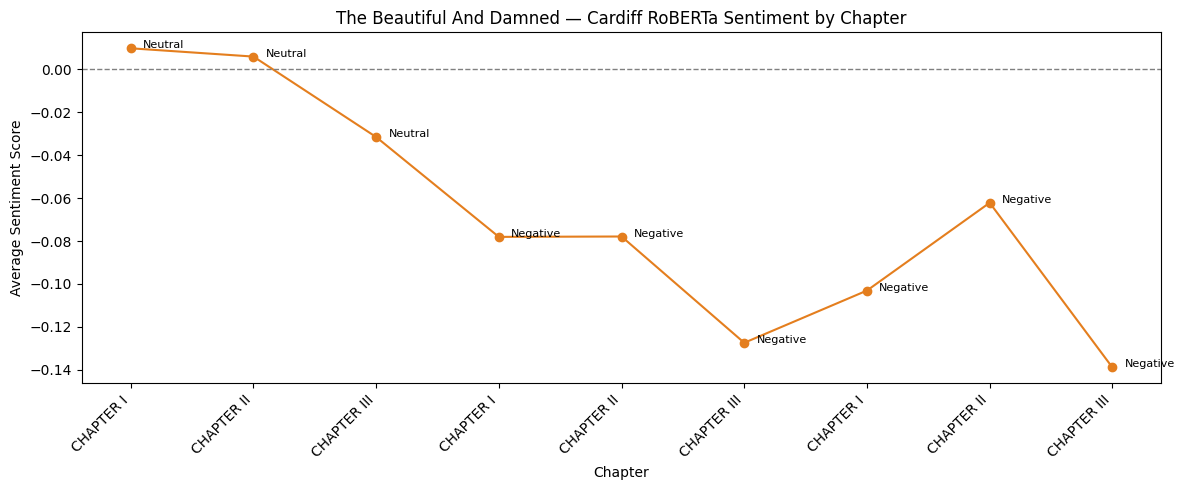

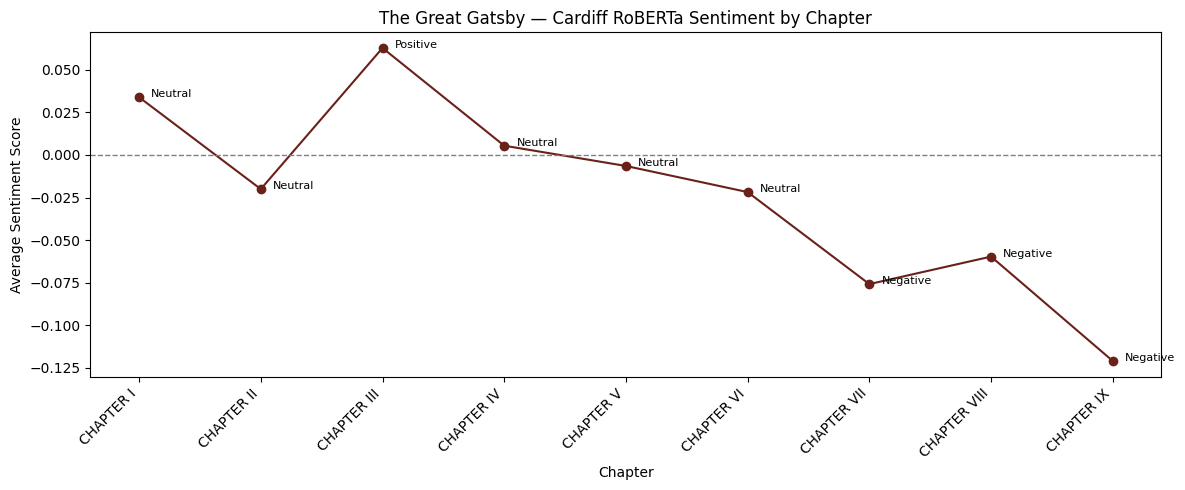

In [13]:
for title, color in zip(BOOKS, colors):

    csv_path = TRANSFORMER_RESULTS_DIR / f"{title}-sentiment-analysis-per-chapter-cardiff-roberta.csv"
    figure_path = TRANSFORMER_FIGURES_DIR / f"{title}-sentiment-analysis-per-chapter-cardiff-roberta.png"

    if not clean_path.exists():
        print(f"File not found: {clean_path}")
        continue

    chapters = []
    scores = []
    labels = []

    with open(csv_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            chapters.append(row["chapter"])
            scores.append(float(row["avg_sentiment_score"]))
            labels.append(row["sentiment_label"])

    pretty_title = title.replace("-", " ").title()

    plt.figure(figsize=(12, 5))
    plt.plot(scores, marker = "o", color = color)

    for i, label in enumerate(labels):
        plt.text(i + 0.1, scores[i], label, fontsize = 8)

    plt.axhline(0, color = "gray", linestyle = "--", linewidth = 1)
    plt.xticks(ticks=range(len(chapters)), labels = chapters, rotation = 45, ha = "right")
    plt.title(f"{pretty_title} — Cardiff RoBERTa Sentiment by Chapter")
    plt.xlabel("Chapter")
    plt.ylabel("Average Sentiment Score")
    plt.tight_layout()
    plt.savefig(figure_path)

Across all three novels, Cardiff RoBERTa tends to lean slightly negative, especially as the stories progress.

In This Side of Paradise, the early chapters come across as mostly neutral, but sentiment steadily dips into negative territory, reflecting an emotional or narrative decline. Later chapters consistently score below zero, suggesting a shift toward darker or more introspective content.

The Beautiful and Damned shows a similar pattern. It starts out fairly neutral but becomes increasingly negative over time. By the second half of the book, almost every chapter is labeled negative, which aligns with the novel’s growing emotional weight and instability.

In The Great Gatsby, sentiment remains more balanced overall. Early and mid chapters are mostly neutral or slightly positive, with a mild downturn in the final chapters. While still less upbeat than VADER’s readings, RoBERTa captures a more subtle descent into melancholy by the novel’s end.

## VADER vs Cardiff RoBERTa

With the sentiment analysis complete, this section takes a closer look at how VADER and Cardiff RoBERTa perform and how each model interprets the emotional tone throughout the texts.

#### **Model Overview**

| Model               | Strengths                                              | Weaknesses                                                    |
| ------------------- | ------------------------------------------------------ | ------------------------------------------------------------- |
| **VADER**           | Fast, rule-based, good for short social/text-like data | Misses context, sarcasm, deeper narrative tones               |
| **Cardiff RoBERTa** | Context-aware, better at literary/narrative nuance     | Slower, may be slightly more negative in tone across chapters |

#### **Sentence Sentiment Analysis Comparison**

| Title                    | VADER Avg | VADER Label | Cardiff RoBERTa Avg | Cardiff RoBERTa Label |
| ------------------------ | --------- | ----------- | ------------------- | --------------------- |
| This Side of Paradise    | **0.06**  | Positive    | **-0.07**           | Negative              |
| The Beautiful and Damned | **0.04**  | Neutral     | **-0.07**           | Negative              |
| The Great Gatsby         | **0.03**  | Neutral     | **-0.03**           | Neutral               |

**Observations:**

- VADER leans more positive overall.
- Cardiff RoBERTa is notably more **negative**, especially for the first two titles.

#### **Sentiment Analysis Per Chapter Comparison: This Side of Paradise**

| Chapter     | VADER Avg | VADER Label | Cardiff RoBERTa Avg | Cardiff RoBERTa Label |
| ----------- | --------- | ----------- | ------------------- | --------------------- |
| CHAPTER I   | 0.11      | Positive    | 0.02                | Neutral               |
| CHAPTER II  | 0.09      | Positive    | 0.01                | Neutral               |
| CHAPTER III | 0.01      | Neutral     | -0.13               | Negative              |
| CHAPTER IV  | 0.05      | Positive    | -0.11               | Negative              |
| CHAPTER I   | 0.10      | Positive    | -0.04               | Neutral               |
| CHAPTER II  | 0.04      | Neutral     | -0.13               | Negative              |
| CHAPTER III | 0.05      | Positive    | -0.06               | Negative              |
| CHAPTER IV  | -0.02     | Neutral     | -0.10               | Negative              |
| CHAPTER V   | 0.01      | Neutral     | -0.17               | Negative              |

**Observations:**

- VADER sees the tone as lightly positive overall.
- Cardiff RoBERTa detects **much more negativity**, especially in later chapters, likely due to **contextual sadness, inner turmoil**, or narrative complexity.

#### **Sentiment Analysis Per Chapter Comparison: The Beautiful and Damned**

| Chapter     | VADER Avg | VADER Label | Cardiff RoBERTa Avg | Cardiff RoBERTa Label |
| ----------- | --------- | ----------- | ------------------- | --------------------- |
| CHAPTER I   | 0.13      | Positive    | 0.01                | Neutral               |
| CHAPTER II  | 0.09      | Positive    | 0.01                | Neutral               |
| CHAPTER III | 0.06      | Positive    | -0.03               | Neutral               |
| CHAPTER I   | 0.05      | Neutral     | -0.08               | Negative              |
| CHAPTER II  | 0.02      | Neutral     | -0.08               | Negative              |
| CHAPTER III | 0.01      | Neutral     | -0.13               | Negative              |
| CHAPTER I   | -0.01     | Neutral     | -0.10               | Negative              |
| CHAPTER II  | 0.04      | Neutral     | -0.06               | Negative              |
| CHAPTER III | 0.00      | Neutral     | -0.14               | Negative              |

**Observations:**

- VADER’s scores hover near zero = **bland sentiment detection**.
- Cardiff RoBERTa interprets emotional **decline and instability** much more starkly.

#### **Sentiment Analysis Per Chapter Comparison: The Great Gatsby**

| Chapter      | VADER Avg | VADER Label | Cardiff RoBERTa Avg | Cardiff RoBERTa Label |
| ------------ | --------- | ----------- | ------------------- | --------------------- |
| CHAPTER I    | 0.04      | Neutral     | 0.03                | Neutral               |
| CHAPTER II   | 0.01      | Neutral     | -0.02               | Neutral               |
| CHAPTER III  | 0.08      | Positive    | 0.06                | Positive              |
| CHAPTER IV   | 0.07      | Positive    | 0.01                | Neutral               |
| CHAPTER V    | 0.03      | Neutral     | -0.01               | Neutral               |
| CHAPTER VI   | 0.05      | Positive    | -0.02               | Neutral               |
| CHAPTER VII  | -0.01     | Neutral     | -0.08               | Negative              |
| CHAPTER VIII | 0.07      | Positive    | -0.06               | Negative              |
| CHAPTER IX   | -0.01     | Neutral     | -0.12               | Negative              |

- VADER finds even tragic chapters like VIII mildly positive!.
- Cardiff RoBERTa **catches the darker emotional tone** of Gatsby's later chapters more accurately.

#### **Final Insights**

- **VADER** is more **positively skewed**, especially at the sentence level.
- **Cardiff RoBERTa** tends to assign more **negative sentiment**, especially across later chapters.
- They agree most on *The Great Gatsby*, but differ significantly on the other two titles.
- Cardiff RoBERTa’s Sentiment per Chapter shows **increasing negativity over time**, possibly picking up what VADER misses.

## Do the Results Make Sense?

Looking at the sentiment analysis, the results generally align well with what’s commonly known about Fitzgerald’s novels.

**This Side of Paradise** and **The Beautiful and Damned** both show stronger negativity and greater emotional swings, which fits their themes of youthful restlessness, disillusionment, and moral decline. These novels explore the messy, turbulent sides of coming of age and societal pressures, so a more negative and volatile emotional tone makes sense.

On the other hand, **The Great Gatsby** appears more emotionally stable and less negative overall, especially compared to the others. This matches its reputation as a more polished and tightly structured work, even though it’s ultimately a tragic story. The subtle negativity detected—especially in later chapters—also reflects the underlying tension and darker themes beneath the surface glamour.

So, the sentiment patterns captured by both VADER and Cardiff RoBERTa do seem to reflect the emotional and thematic differences between these books, confirming that the analysis results make sense in the context of Fitzgerald’s storytelling.